In [44]:
import matplotlib
import sys
sys.path.append('..')
from er_simulator.wc_model import WCTaskSim
from er_simulator.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from er_simulator.load_wc_params import load_wc_params
from er_simulator.boldIntegration import BWBoldModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, stats, io

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation of fmri data with changing synaptic weigths

The package allows users to generate fMRI time series, based on modification on Wilson-Cowan model implemented in neurolib library (Cakan, C., Jajcay, N. & Obermayer, K. neurolib: A Simulation Framework for Whole-Brain Neural Mass Modeling. Cogn. Comput. (2021). https://doi.org/10.1007/s12559-021-09931-9). The main differences from neurolib realization: 
  - possibility to change synaptic weight matrix with the time
  - possibility to use synaptic activity as output instead of excitation or inhibition (as described in Horwitz and Tagamets (1999))
  - possibility to save neural signal with lower resolution
  - possibility to change TR in bold signal convolution
  - possibility to change HRF type for convolution

Example with three different synaptic weight matrices for rest,  task A and B demonstrated below

### Matrix generation

In [45]:
num_regions = 30
num_modules = 3
X = 0.9
Z = 0.4
rest_factors = np.array([[X, 0.1, 0.1],
                                 [0.1, X, 0.1],
                                 [0.1, 0.1, X]])
taskA_factors = np.array([[X, Z, 0.1],
                                  [Z, X, 0.1],
                                  [0.1, 0.1, X]])
taskB_factors = np.array([[X, 0.1, Z],
                                  [0.1, X, 0.1],
                                  [Z, 0.1, X]])

c_rest = generate_synaptic_weights_matrices(num_regions,
                                            num_modules,
                                            factors=rest_factors,
                                            sigma=0.1)
c_task_a = generate_synaptic_weights_matrices(num_regions,
                                              num_modules,
                                              factors=taskA_factors,
                                              sigma=0.1)
c_task_b = generate_synaptic_weights_matrices(num_regions,
                                                      num_modules,
                                                      factors=taskB_factors,
                                                      sigma=0.1)
D = np.ones((num_regions, num_regions)) * 250
np.fill_diagonal(D, 0)
norm_type = "cols"
Wij_rest = normalize(c_rest, norm_type=norm_type)
c_task_a = normalize(c_task_a, norm_type=norm_type)
c_task_b = normalize(c_task_b, norm_type=norm_type)
Wij_task_dict = {"task_A": c_task_a, "task_B": c_task_b}

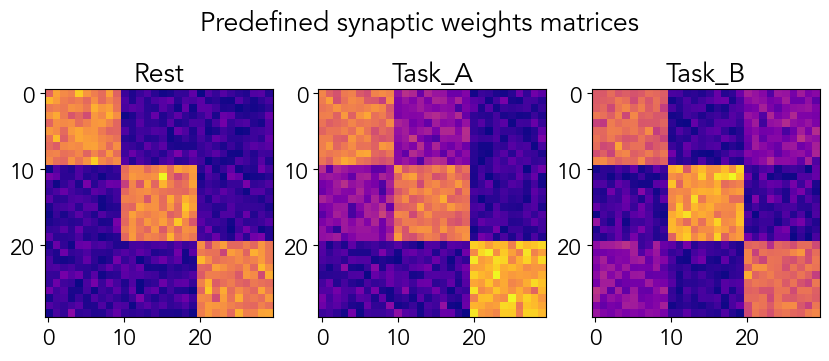

In [46]:
titles = ["Rest", "Task_A", "Task_B"]
syn_mats = [Wij_rest, c_task_a, c_task_b]
fig, axs = plt.subplots(1, 3, figsize = (10,4))
for i, (title, C) in enumerate(zip(titles, syn_mats)):
    axs[i].imshow(C); axs[i].set_title(title);
fig.suptitle("Predefined synaptic weights matrices"); 

## Block design

Here, we demonstrated simple block design [rest, task_A, rest, task_B, rest , task_A, rest, task_B, rest]
Durations:
 - rest  = 16 s
 - task_A = 32s 
 - task_B = 32s

so, onsets should be = [16, 64, 112, 160]

Also first 8 second usually droped out after bold convolution, so additionally added first_duration,
typical TR chosen 2s

Generation take time!

In [47]:
bw_params_fix = {"normalize_constant": 2,
                 "alpha": 0.32,
                 "rho":0.34,
                 "tau":0.98,
                 "gamma":0.41,
                 "k":0.65
                }

wc_block = WCTaskSim(bold_params=bw_params_fix, 
                     C_rest=Wij_rest,
                     C_task_dict = Wij_task_dict,
                     D=D,
                     output_type="all",
                     TR=2,
                     fMRI_T=100,
                     onset_time_list = [16, 64, 112, 160],
                     duration_list=32,
                     task_name_list=["task_A","task_B","task_A","task_B"],
                     rest_before=6,
                     rest_after=64
                    )

In [48]:
%%time
wc_block.generate_full_series(compute_bold=True)

CPU times: user 17.6 s, sys: 1.16 s, total: 18.7 s
Wall time: 18.3 s


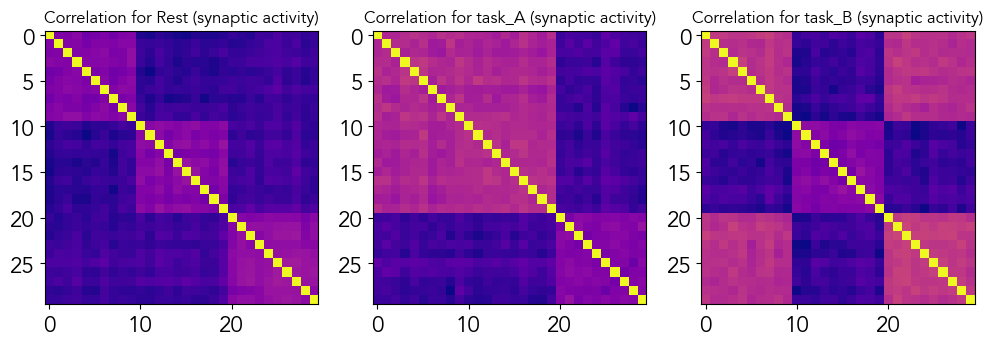

In [50]:
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'mtime',  'syn_act')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]} (synaptic activity)", fontsize=12);
                        

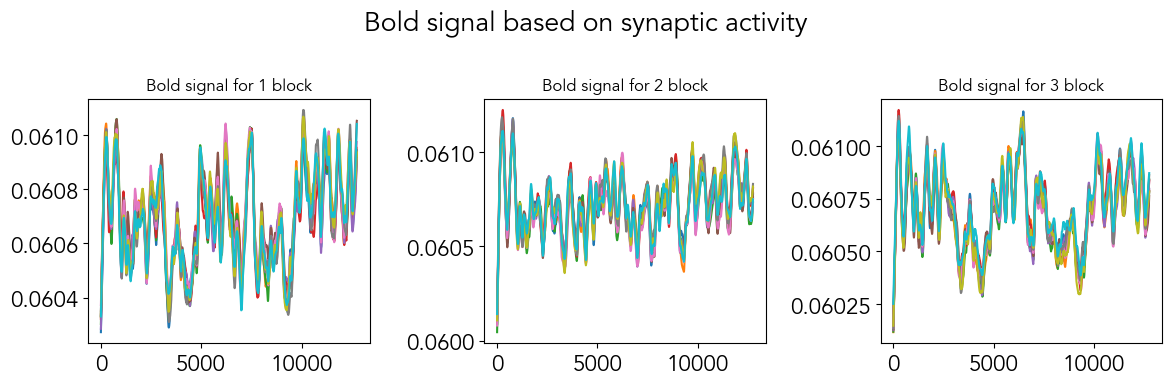

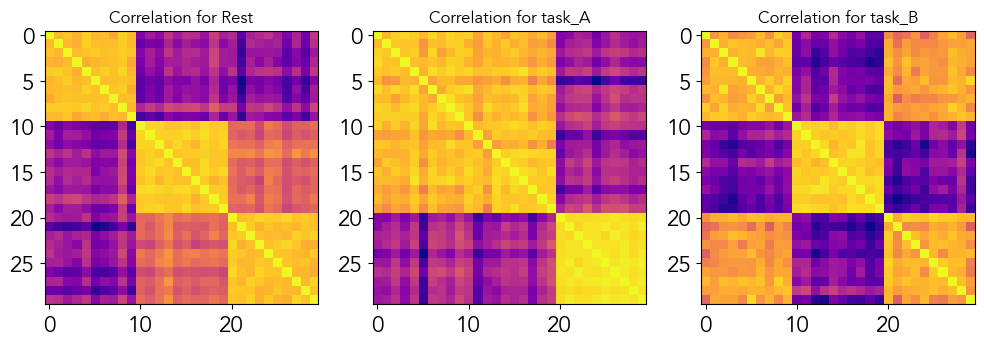

In [51]:
tune = int(7/ wc_block.mTime)
ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'mtime',  'BOLD')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);


## Random parameters for bold

In [52]:
bw_params_low_var = {"normalize_constant": 2,
                     "fix": False,
                     "alpha": (0.32, 0.00000015),
                     "rho":(0.34, 0.000000024),
                     "tau":(0.98, 0.000000568),
                     "gamma":(0.41, 0.00000002),
                     "k":(0.65, 0.000000015),
            }

bw_params_random = {"normalize_constant": 2,
                    "fix": False,
                    "alpha": (0.32, 0.0015),
                    "rho":(0.34, 0.0024),
                    "tau":(0.98, 0.0568),
                    "gamma":(0.41, 0.002),
                    "k":(0.65, 0.015)
            }

CPU times: user 14.6 s, sys: 1.06 s, total: 15.6 s
Wall time: 15.2 s


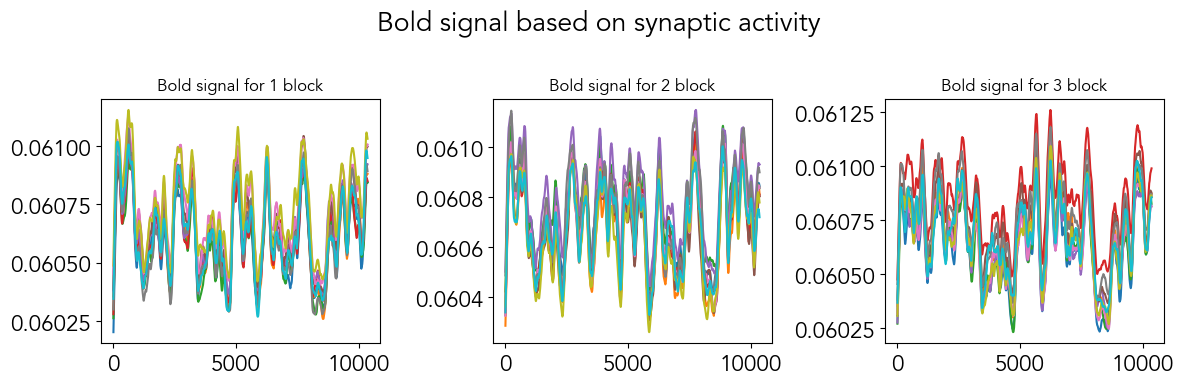

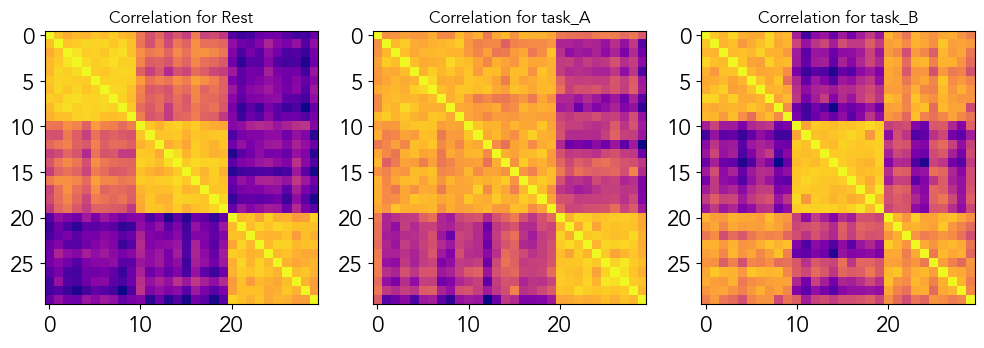

In [53]:
%%time
wc_block = WCTaskSim(bold_params=bw_params_low_var, 
                     C_rest=Wij_rest,
                     C_task_dict = Wij_task_dict,
                     D=D,
                     output_type="all",
                     TR=2,
                     fMRI_T=100,
                     onset_time_list = [16, 64, 112, 160],
                     duration_list=32,
                     task_name_list=["task_A","task_B","task_A","task_B"],
                     rest_before=6,
                     rest_after=16
                    )
wc_block.generate_full_series(compute_bold=True)
tune = int(7/ wc_block.mTime)
ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'mtime',  'BOLD')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);

CPU times: user 15 s, sys: 1.11 s, total: 16.1 s
Wall time: 15.8 s


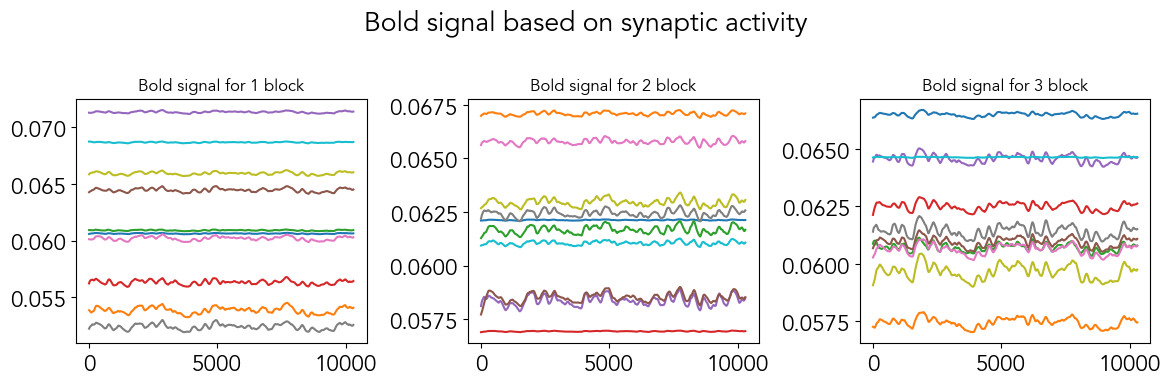

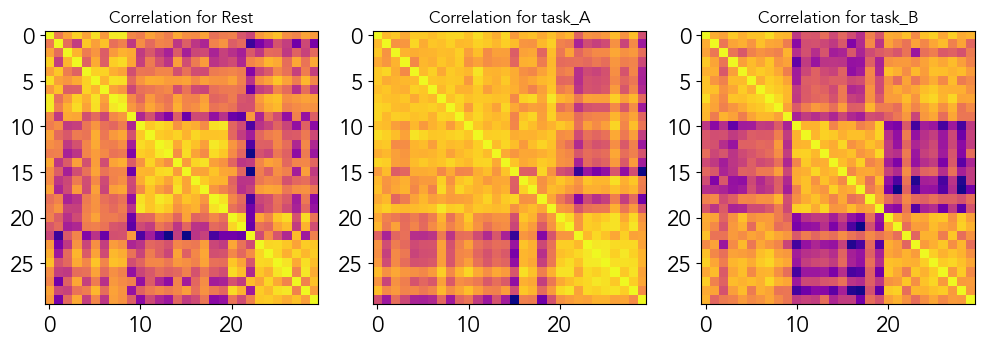

In [54]:
%%time
wc_block = WCTaskSim(bold_params=bw_params_random, 
                     C_rest=Wij_rest,
                     C_task_dict = Wij_task_dict,
                     D=D,
                     output_type="all",
                     TR=2,
                     fMRI_T=100,
                     onset_time_list = [16, 64, 112, 160],
                     duration_list=32,
                     task_name_list=["task_A","task_B","task_A","task_B"],
                     rest_before=6,
                     rest_after=16
                    )
wc_block.generate_full_series(compute_bold=True)
tune = int(8/ wc_block.mTime)
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'mtime',  'BOLD')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);

## Saving parameters
supported saving to npy, hdf5 and mat

In [55]:
wc_block.boldModel.save_imp_with_params('bold_params.mat', s_type='mat')
#for loading
#io.loadmat("bold_params.mat")

In [56]:
wc_block.boldModel.save_imp_with_params('bold_params.npy', s_type='npy')
bold_params_array = np.load("bold_params.npy", allow_pickle=True).item()

In [57]:
print(bold_params_array.keys(), bold_params_array['unit_impulse'].keys())

dict_keys(['normalize_constant', 'fix', 'rho', 'alpha', 'gamma', 'k', 'tau', 'unit_impulse']) dict_keys(['time', 'BOLD'])


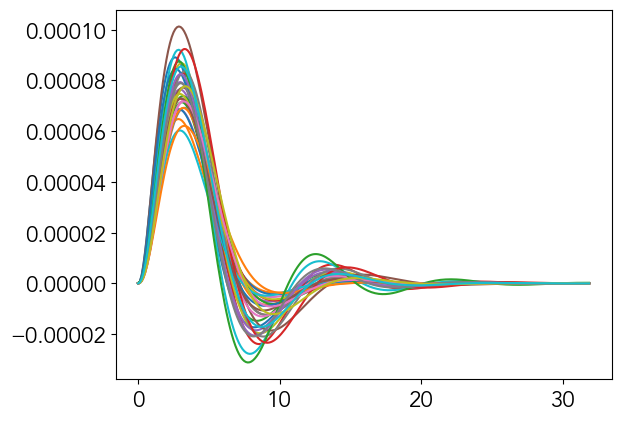

In [58]:
plt.plot(bold_params_array['unit_impulse']['time'],bold_params_array['unit_impulse']['BOLD'].T);

CPU times: user 18.1 s, sys: 1.22 s, total: 19.3 s
Wall time: 18.7 s


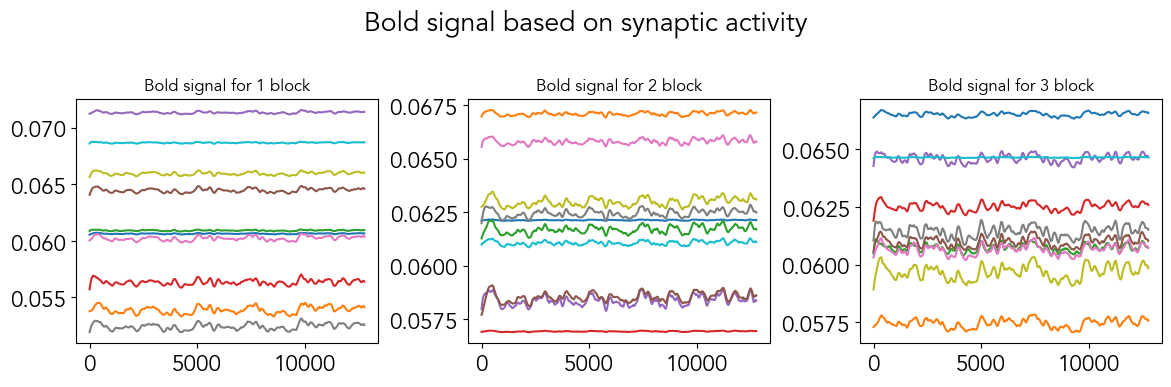

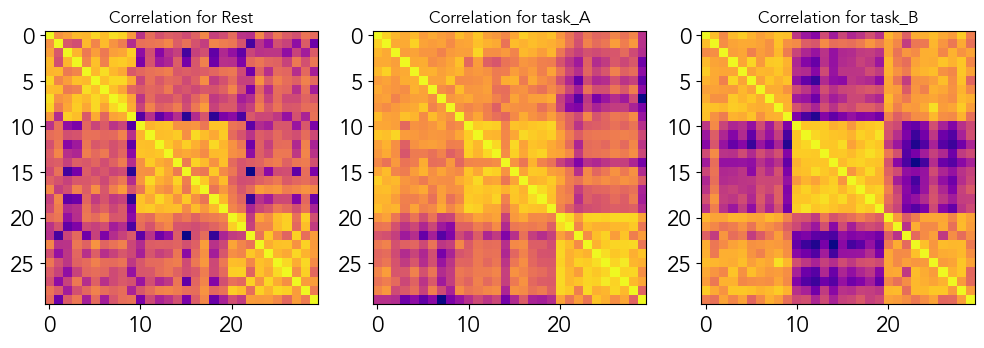

In [59]:
%%time
wc_block = WCTaskSim(bold_params=bold_params_array, 
                     C_rest=Wij_rest,
                     C_task_dict = Wij_task_dict,
                     D=D,
                     output_type="all",
                     TR=2,
                     fMRI_T=100,
                     onset_time_list = [16, 64, 112, 160],
                     duration_list=32,
                     task_name_list=["task_A","task_B","task_A","task_B"],
                     rest_before=6,
                     rest_after=64
                    )
wc_block.generate_full_series(compute_bold=True)
tune = int(7/ wc_block.mTime)
ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'mtime',  'BOLD')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);

## BOLD in TR time

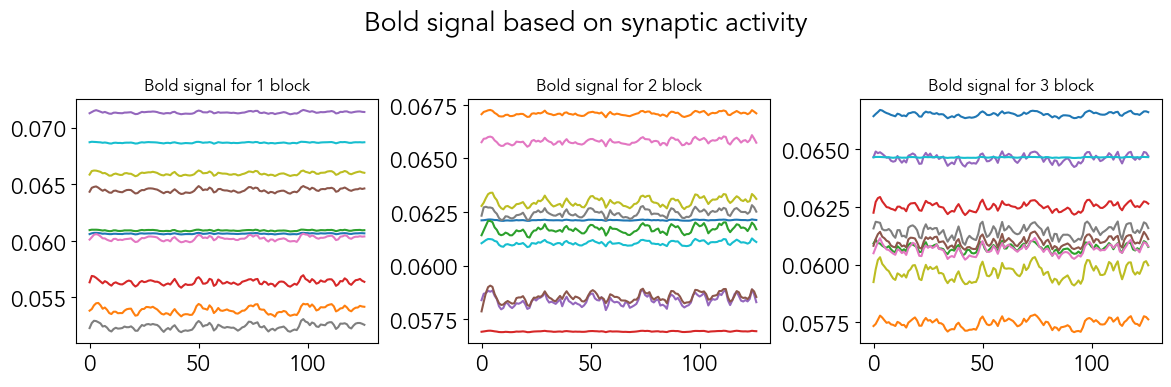

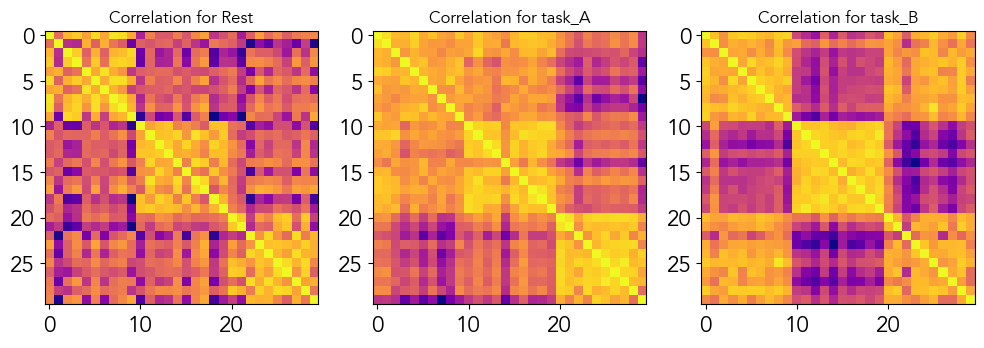

In [60]:
tune = int(8/ wc_block.TR)
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.output['BOLD_TR'][i*10:i*10+10,tune:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
fig, axs = plt.subplots(1, 3, figsize = (12,4))
t_names = ['Rest', 'task_A', 'task_B']
for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'TR_time',  'BOLD_TR')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);

for i in range(3):
    concat_series = wc_block.get_task_block(t_names[i], 'TR_time',  'BOLD_TR')
    corr_series = np.corrcoef(concat_series)
    axs[i].imshow(corr_series)
    axs[i].set_title(f"Correlation for {t_names[i]}", fontsize=12);

In [61]:
wc_block.get_task_block('task_A', 'mtime',  'BOLD').shape

(30, 2598)